### Helper Functions

In [1]:
import pandas as pd
import numpy as np
# import os

from ipywidgets import IntProgress
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from matplotlib import gridspec

plt.rcParams.update({'font.size': 12})

from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline



#Data Type for ROC graphs (Data name, False Positives, True Positives, False Negatives, True Negatives)
def ROC_DATA(label, FP='-', TP='-', FN='-', TN='-', THRESHOLD='-'):
    obj = {'Label':label }
    if(not(FP is '-')):
        obj['FP'] = FP
    if(not(FN is '-')):
        obj['FN'] = FN
    if(not(TP is '-')):
        obj['TP'] = TP
    if(not(TN is '-')):
        obj['TN'] = TN
    if(not(THRESHOLD is '-')):
        obj['THRESHOLD'] = THRESHOLD
    return obj



#makes ROC_DATA for a all columns in a df
def getRate(df, col, label='Default'):
    FP, TP = [], []
    FN, TN = [], []
    THRESHOLD = []
    for i in range(0, 100):
        threshold=i/100.
        THRESHOLD.append(threshold)
        FP.append(len(df[(df[col]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        TP.append(len(df[(df[col]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        FN.append(len(df[(df[col]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        TN.append(len(df[(df[col]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
    return ROC_DATA(label, TP=TP, FP=FP, TN=TN, FN=FN, THRESHOLD=THRESHOLD)
    
#Limits columns in a DF to  particular value
def limitVal(df, ignore = ['Success'], N = np.finfo(np.float32).max):
    for c in df.drop(columns=ignore).columns:
#         df[c].loc[df[c] >= N] = N
#         print(df[c].dtype)
        if(not (df[c].dtype == 'bool')):
            df[c] = df[c].where(df[c] <= 1., 1.) 
    return df


#Takes the average of all columns in a df
def avgVal(df, colName = "AvgPred", JUST_PREDS=False, verbose=False):
    ignore = []
    if('Success' in df.columns):
        ignore.append('Success')
    if(JUST_PREDS):
        for col in df.columns:
            if(not(col[:4]=='Pred')):
#                 print(col)
                ignore.append(col)
            elif(verbose):
                print(col)
    df[colName] = df.drop(columns=ignore).mean(axis=1)
    return df


#Plot an array of ROC_DATA
def plotRocs(rocObjArray):
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    ax = fig.add_subplot(1,1,1)
    for rocData in rocObjArray:
        d = rocData
        label = d['Label']
        FP, TP = d['FP'], d['TP']
        ax.plot(FP,TP,'-', lw=3,label = label, zorder = -32, alpha=.5)
    handles, labels = ax.get_legend_handles_labels()
    display = (0,71)
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim(0,1)
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title(V_Prefix + ' ROC Curve Comparison')
    ax.legend()
    
    
from colour import Color
red = Color("red")
colormap = list(red.range_to(Color("green"),100))
def mapToColors(values):
    colors = []
    for v in values:
        i = int(v*100)
        colors.append(str(colormap[i]))
    return colors

#Plot a single ROC_DATA with THRESHOLD as a second x-axis
def plotColorRoc(rocData, vault=""):
    # plot it
    fig = plt.figure(figsize=(6, 5)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, .25]) 

    ax0 = plt.subplot(gs[0])
    d = rocData
    label = d['Label']
    
    FP, TP = d['FP'], d['TP']
    THRESHOLD = d['THRESHOLD']
    COLORS = mapToColors(THRESHOLD)
    for i in range(1, len(FP)):
        ax0.plot((FP[i-1], FP[i]),(TP[i-1], TP[i]), c = COLORS[i], label = "FP", lw=3.)
        
    ax0.set_xlabel('False Positive Rate')
    ax0.set_xlim(0,1)
    ax0.set_ylabel('True Positive Rate')
    ax0.set_ylim(0,1)
    ax0.set_title(vault + " ["+ label+ "]")
    ax0.grid(color='black', linestyle='-', linewidth=1, alpha=.5)


    ax1 = plt.subplot(gs[1])
    ax1.yaxis.tick_right()
    ax1.set_xlim(0,1)
    ax1.get_xaxis().set_visible(False)
    ax1.set_ylabel('Threshold')
    ax1.set_ylim(0,1)

    values = np.arange(0., 1., .01)
    for i in range(0, 100):
        plt.plot((0, 1.), (values[i], values[i]), c = str(colormap[i]), lw=4)

In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Samples DF for an approximate numnber of rows  (Needed for balanceDF)
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

#Returns DF with 50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    failDF = df[df[colName]==False]
    successDF = df[df[colName]==True]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF

#Splits a df into two parts, for testing and training
def splitTrainingTesting(df, percentTrain, TYPE='None', basedOnVault=False):
    if(not basedOnVault):
        df = df.copy(deep=True)
        if(TYPE=="CLF"):
            df['Success'] = df['Success'].astype('int')
        elif(TYPE=='REGR'):
            df['Success'] = df['Success'].astype('float')
        df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
        trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
        df = df.drop(columns=['is_train'], axis=1)
        trainDF = trainDF.drop(['is_train'], axis=1)
        testDF = testDF.drop(['is_train'], axis=1)
        return trainDF, testDF
    else:
        nonVault = pd.merge(nonVaultDF, df, on='ContestId', how='left')
        vault = df[~df.index.isin(nonVault.index)].dropna()
#         return len(vault), len(nonVault)
        numTrain = len(nonVault)
        numTest = int((1-percentTrain)*numTrain)
        vault.sample(n=numTest, random_state=1)
        return nonVault, vault.sample(n=numTest, random_state=1)


#Simple wrapper for a making a classifier
def classifierWrapper(trainDF, classifierType, balanced=True):
    trainDF = trainDF.copy(deep=True)
    if(balanced):
        trainDF = balanceDF(trainDF, 'Success')
    clf = makeAndTrainCLF(trainDF, classifierType)
    columns = trainDF.columns.drop('Success')
    return {"clf":clf, "cols":columns}

#Trains a classifier of the provided 
def makeAndTrainCLF(trainDF, classifierType, successCol = 'Success'): ####################
    clf = classifierType()
    clf.fit(trainDF[trainDF.columns.drop(successCol)], trainDF[successCol].astype('int'))
    return clf


def EnsembleWithMinAcc(trainDF, classifierType, balanced=True, numCLF = 50, accuracy=0.):
    CLFS = []
    for i in range(0, numCLF):
        currAcc = -1.
        while(currAcc < accuracy):
            clf = classifierWrapper(trainDF, RandomForestClassifier, balanced=balanced)
            currAcc = accuracy_score(clf['clf'].predict(trainDF[clf['cols']]), trainDF['Success'])
        CLFS.append(clf)
    return CLFS

def getEnsPred(testDF, CLFS):
    rDF = testDF[['Success']].copy(deep=True)
    count = 0
    for CLF in CLFS:
        count+=1
        classifier, columns = CLF['clf'], CLF['cols']
        rDF['CLF'+str(count)] = classifier.predict(testDF[columns])
    return rDF

def filterColumns(columns, contains):
    return list(filter(lambda x : contains in x, list(columns)))

In [3]:
def combinePredictions(testDF, metaCLFs, fullCLFs):
    metaPreds = avgVal(getEnsPred(testDF, metaCLFs))
    metaPreds = metaPreds.rename(columns={'AvgPred':'MetaPred'})[['MetaPred', 'Success']]
    
    fullPreds = avgVal(getEnsPred(testDF, fullCLFs))
    fullPreds = fullPreds.rename(columns={'AvgPred':'FullPred'})[['FullPred']]
    
    merged = pd.merge(fullPreds, metaPreds, on='ContestId', how='right')
    merged = merged.assign(HasNoPrediction = lambda contest: (contest.index.isin(tooShortIds)).astype(np.int32))
    
    merged = merged.assign(SituationalPrediction = merged.FullPred*(1-merged.HasNoPrediction) + merged.MetaPred*merged.HasNoPrediction)
    return merged

### Importing Data

In [4]:
fullContests = pd.read_csv('data/WorkingData.csv').set_index('ContestId')
fullContests = fullContests.reset_index().drop_duplicates(subset='ContestId').set_index('ContestId')

In [5]:
# Percent Full at 4 hours out
baselineDF = pd.read_csv('data/baseline.csv').drop(columns=['Unnamed: 0'])
# Meta Data file
metaDataDF = pd.read_csv('data/MetaData.csv')
# Kalman Filter
kfResultsDF = pd.read_csv('data/KF_Results.csv')
# Linear Regression
lrResultsDF = pd.read_csv('data/LR_Results.csv')

In [7]:
trainDF = pd.read_csv("data/Vault/train.csv").set_index('ContestId')
trainDF = trainDF.reset_index().drop_duplicates(subset='ContestId').set_index('ContestId')
testDF = pd.read_csv("data/Vault/test1.csv").set_index('ContestId')
testDF = testDF.reset_index().drop_duplicates(subset='ContestId').set_index('ContestId')
print("Number of contests in trainDF:",len(trainDF))
print("Number of contests in testDF:",len(testDF))

Number of contests in trainDF: 372121
Number of contests in testDF: 64509


In [8]:
trainDFs = {}
for i in range(1,5):
    df = pd.read_csv("data/Vault/test"+str(i)+".csv")
    df = df.drop_duplicates(subset='ContestId').set_index('ContestId')
    trainDFs[i] = df

In [10]:
tooShortDF = pd.read_csv('data/LR_Results.csv').set_index('ContestId')
tooShortDF = avgVal(tooShortDF, JUST_PREDS=True)
tooShortIds = tooShortDF[tooShortDF['AvgPred']==0].index
tooShortDF2 = pd.read_csv('data/KF_Results.csv').set_index('ContestId')
tooShortDF2 = avgVal(tooShortDF2, JUST_PREDS=True)
tooShortIds = set(list(tooShortIds) + list(tooShortDF[tooShortDF['AvgPred']==0].index))

In [11]:
pacerDF = pd.read_csv('data/DK_Pacer_Success.csv').set_index('ContestId')

In [12]:
pacerRate = getRate(pacerDF, 'PacerSuccess', label='Pacer Prediction')

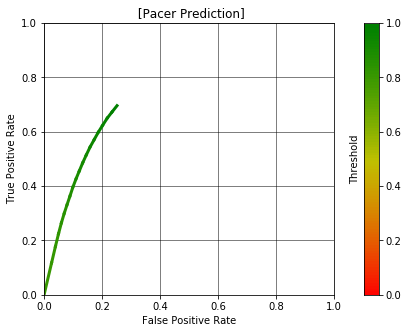

In [13]:
plotColorRoc(pacerRate)

### Generating Classifiers

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
kfColumns = list(kfResultsDF.columns.drop('ContestId'))
lrColumns = list(lrResultsDF.columns.drop('ContestId'))
metaColumns = list(metaDataDF.columns.drop('ContestId'))

kfColumns.append('Success')
lrColumns.append('Success')
metaColumns.append('Success')

fullColumns = list(set(metaColumns+lrColumns+kfColumns))

In [16]:
print("Generating Classifiers for Header Data")
metaCLFS = EnsembleWithMinAcc(limitVal(trainDF[metaColumns]), RandomForestClassifier, accuracy = .6)
print("Generating Classifiers for Full Data")
fullCLFS = EnsembleWithMinAcc(limitVal(trainDF[~trainDF.index.isin(tooShortIds)]), RandomForestClassifier, accuracy = .6)

Generating Classifiers for Header Data
Generating Classifiers for Full Data


In [17]:
fillDF = fullContests[['MaxNumberPlayers', 'Entries', 'EntryFeeAmount']]
fillDF = fillDF.assign(FillEntries = fillDF.MaxNumberPlayers - fillDF.Entries)
fillDF = fillDF.assign(FillDollars = fillDF.FillEntries * fillDF.EntryFeeAmount)

In [18]:
preds = combinePredictions(limitVal(testDF), metaCLFS, fullCLFS)
preds = pd.merge(preds, fillDF, on='ContestId', how='left')

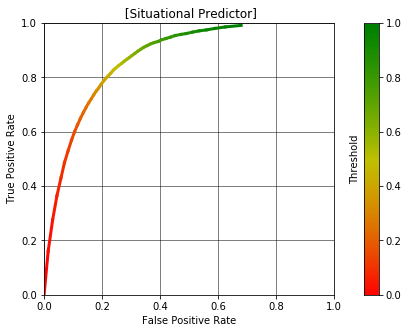

In [19]:
plotColorRoc(getRate(preds, 'SituationalPrediction', label='Situational Predictor'))

### Analytics

In [22]:
from ipywidgets import *
plt.rcParams.update({'font.size': 16})

In [23]:
from IPython.display import HTML, display
import tabulate
def f2Score(df, typeCol='Type'):
    table = [['', 'True', 'False'], 
             ['Positive', len(df[df[typeCol]=='TP']), len(df[df[typeCol]=='FP'])], 
             ['Negative', len(df[df[typeCol]=='TN']), len(df[df[typeCol]=='FN'])]]
    display(HTML(tabulate.tabulate(table, tablefmt='html')))

def assignType(df, predCol='Prediction', truthCol='Success'):
    df = df.assign(TypeVal = 0)
    types = ['TP', 'TN', 'FP', 'FN']    
    TP = df[~df[predCol] & ~df[truthCol]].assign(Type = 'TP')   
    TN = df[df[predCol] & df[truthCol]].assign(Type = 'TN')
    FP = df[~df[predCol] & df[truthCol]].assign(Type = 'FP')
    FN = df[df[predCol] & ~df[truthCol]].assign(Type = 'FN')
    return pd.concat([TP, TN, FP, FN])

def calculateMultipler(df, typeCol = 'Type', FN_COST = 10, FP_COST=1, TN_COST=0, TP_COST=0):
    df = df.assign(Multiplier = 0)
    df['Multiplier'] = df['Multiplier'] + (df[typeCol] == 'FN')*FN_COST
    df['Multiplier'] = df['Multiplier'] + (df[typeCol] == 'FP')*FP_COST
    df['Multiplier'] = df['Multiplier'] + (df[typeCol] == 'TN')*TN_COST
    df['Multiplier'] = df['Multiplier'] + (df[typeCol] == 'TP')*TP_COST
    return df

In [24]:
dfs = []
scores = []
best = -1
bestIndex = -1
gapsFN = []
gapsTP = []
gapsCost = []

for i in range(0, 101):
    thresh = i/100
    adf = preds.assign(Prediction = preds.SituationalPrediction >= thresh).copy(deep=True)
    adf = calculateMultipler(assignType(adf))[['Type', 'Multiplier', 'Success', 
                                               'Prediction', 'FillEntries', 'FillDollars']]
    dfs.append(adf)
    gapFN = adf
    score = adf.Multiplier.sum()
    scores.append(score)
    gapsFN.append(adf[adf['Type']=='FN'].FillDollars.sum())
    gapsTP.append(adf[adf['Type']=='TP'].FillDollars.sum())
    gapsCost.append(gapsTP[i] - gapsFN[i]*10)
    if(best == -1):
        best = score
        bestIndex = i
    elif(score < best):
        best = score
        bestIndex = i


### Cost

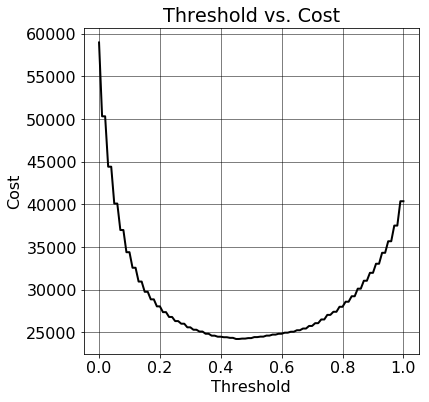

In [25]:
fig = plt.figure(figsize=(6, 6)) 
ax = plt.subplot(1, 1, 1)
ax.set_title('Threshold vs. Cost')
ax.set_xlabel('Threshold')
ax.set_ylabel('Cost')
ax.plot(np.arange(0, 101)/100, scores, c='k', lw='2.')
ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
plt.show()

In [26]:
print("Best threshold is", bestIndex/100, 'with a score of', best)
f2Score(dfs[bestIndex])

Best threshold is 0.45 with a score of 24234


,True,False
Positive,4881,14074
Negative,44538,1016


### True Positives Gap

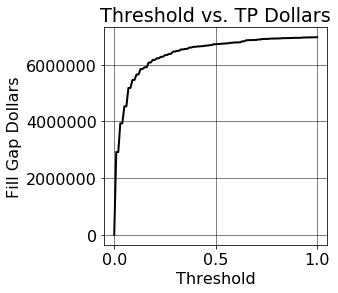

In [27]:
fig = plt.figure(figsize=(4, 4)) 
ax = plt.subplot(1, 1, 1)
ax.set_title('Threshold vs. TP Dollars')
ax.set_xlabel('Threshold')
ax.set_ylabel('Fill Gap Dollars')
ax.plot(np.arange(0, 101)/100, gapsTP, c='k', lw='2.')
ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
plt.show()

In [28]:
print("Best threshold is", bestIndex/100, 'with a TP fillgap of', str(round(100*gapsTP[bestIndex]/gapsTP[100], 2))+'%')
print(round(gapsTP[bestIndex], 2),"/",gapsTP[100], 'dollars')

Best threshold is 0.45 with a TP fillgap of 95.77%
6672365.0 / 6966834.7 dollars


### False Negatives Fillgap

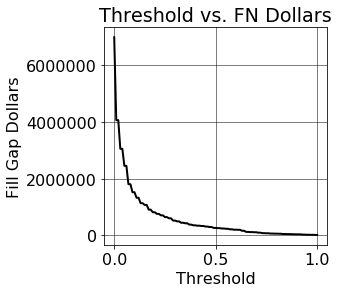

In [29]:
fig = plt.figure(figsize=(4, 4)) 
ax = plt.subplot(1, 1, 1)
ax.set_title('Threshold vs. FN Dollars')
ax.set_xlabel('Threshold')
ax.set_ylabel('Fill Gap Dollars')
ax.plot((np.arange(0, 101)/100), gapsFN, c='k', lw='2.')
ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
plt.show()

In [30]:
print("Best threshold is", bestIndex/100, 'with a FN fillgap of', str(round(100*gapsFN[bestIndex]/gapsFN[0], 2))+'%')
print(round(gapsFN[bestIndex], 2),"/",gapsFN[0], 'dollars')

Best threshold is 0.45 with a FN fillgap of 4.48%
313026.0 / 6985391.0 dollars


### Positive Gap accounting for Number of Positives

In [31]:
curr = dfs[48]

In [32]:
len(curr)

64509

In [33]:
totalGap = curr[(curr['Type'] == 'TP')|(curr['Type'] == 'FN')].FillDollars.sum()
totalContests = len(curr)
numP = []
percentDollars = []
percentP = []
for i in range(0, 101):
    curr = dfs[i]
    numP.append(len(curr[~curr['Prediction']]))
    percentP.append(100*len(curr[~curr['Prediction']]) / len(curr))
    percentDollars.append(100*curr[curr['Type'] == 'TP'].FillDollars.sum() / totalGap)

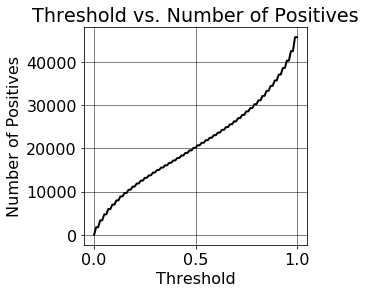

In [34]:
fig = plt.figure(figsize=(4, 4)) 
ax = plt.subplot(1, 1, 1)
ax.set_title('Threshold vs. Number of Positives')
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of Positives')
ax.plot((np.arange(0, 101)/100), numP, c='k', lw='2.')
ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
plt.show()

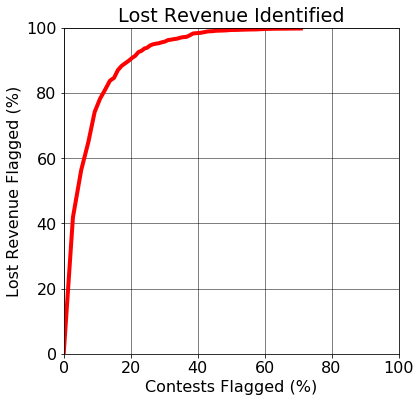

In [35]:
fig = plt.figure(figsize=(6, 6)) 
ax = plt.subplot(1, 1, 1)
ax.set_title('Lost Revenue Identified')
ax.set_xlabel('Contests Flagged (%)')
ax.set_xlim(0, 100)

ax.set_ylabel('Lost Revenue Flagged (%)')
ax.set_ylim(0, 100)

ax.plot(percentP, percentDollars, c='r', lw='4.')
ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
plt.show()

### Imbalanced Data Scatter Plot

In [36]:
contests = pd.read_csv('data/WorkingData.csv').set_index('ContestId')

In [38]:
contests = contests.assign(Success = contests.Entries == contests.MaxNumberPlayers)

In [39]:
successes = contests[contests['Success']].sample(frac=.1, random_state=1)
fails = contests[~contests['Success']].sample(frac=.1, random_state=1)

In [40]:
len(fails)/len(contests)

0.008641501413285199

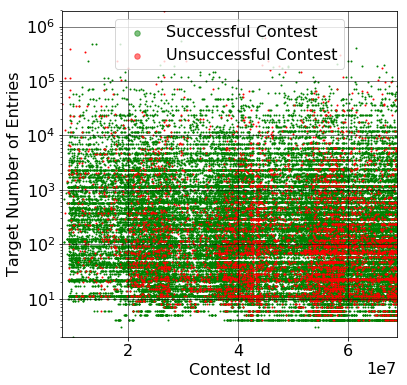

In [41]:
fig = plt.figure(figsize=(6, 6)) 
ax = fig.add_subplot(1, 1, 1)

ax.scatter(successes.index, successes.MaxNumberPlayers, alpha=1.0, s=1.0, c='g', label='')
ax.scatter(fails.index, fails.MaxNumberPlayers, alpha=1.0, s=1.0,c='r', label='')

ax.scatter([1000], [-1000], alpha=.5, s=30.0, c='g', label='Successful Contest')

ax.scatter([1000], [-1000], alpha=.5, s=30.0,c='r', label='Unsuccessful Contest')


# ax.set_xscale('log')
ax.set_xlabel('Contest Id')
ax.set_xlim(contests.index.min(), contests.index.max())

ax.set_yscale('log')
ax.set_ylabel('Target Number of Entries')
ax.set_ylim(0, contests.MaxNumberPlayers.max())

ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
ax.legend()
# ax.set_title('Distrubation of Contests')

plt.show()